# 0. Preparation

In [370]:
import numpy as np
import heapq
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

## 0.1. load data

In [9]:
# 資料位置設置
data_path = "../data/ratings.data"

# 讀取資料
data = np.loadtxt(data_path, dtype=int)
print(data.shape)
print(data[:5])

(100000, 4)
[[      196       242         3 881250949]
 [      186       302         3 891717742]
 [       22       377         1 878887116]
 [      244        51         2 880606923]
 [      166       346         1 886397596]]


In [43]:
# 存取使用者及電影名稱
user = np.unique(data[:,0])
movie = np.unique(data[:,1])
print(user.shape, movie.shape)

(943,) (1682,)


## 0.2. split training data & testing data

In [17]:
# 將資料切分為訓練資料及測試資料
train_data, test_data = train_test_split(data, test_size = 0.25)
print(train_data.shape, test_data.shape)

(75000, 4) (25000, 4)


# 1. Collaborative Filtering (CF)

## 1.1. User-based Collaborative Filtering (U-CF)

In [104]:
# init user_matrix as zero matrix
user_matrix = np.zeros((len(user), len(movie)))

for u in tqdm(user, desc='data transfer user matrix'):
    '''
    train_data[train_data[:,0] == u] : 過濾出u使用者所有的評分資料
    train_data[train_data[:,0] == u][:,1]: 取得u使用者所有評分過的電影名稱
    '''
    rate_index = train_data[train_data[:,0] == u][:,1]
    for rate in rate_index:
        '''
        user_matrix[u-1, rate-1]: 欲設置的rateing位置
        train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)]: 取出u使用者對於評論過特定電影的資料
        '''
        user_matrix[u-1, rate-1] = train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)][:,2].item()

data transfer user matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:13<00:00, 69.93it/s]


In [379]:
# 計算使用者平均評分
user_mean = np.mean(user_matrix, axis = 1)
# 使用個別使用者平均校正使用者對電影的評分
user_adjust = user_matrix - np.reshape(user_mean, (-1, 1))
np.absolute(user_adjust[0][:20])

array([4.57728894, 2.57728894, 3.57728894, 0.42271106, 0.42271106,
       4.57728894, 3.57728894, 0.57728894, 4.57728894, 2.57728894,
       1.57728894, 0.42271106, 4.57728894, 4.57728894, 0.42271106,
       4.57728894, 0.42271106, 3.57728894, 4.57728894, 0.42271106])

In [387]:
# 計算向量長度
def norm_1(v):
    return np.sum(np.absolute(v))

# 計算兩個向量的 cosine 相似度
def cos_sim(a, b):
    return np.inner(a,b) / (norm_1(a)*norm_1(b))

# 計算兩個向量的 Pearson Correlation Coefficient 相似度
def pcc_sim(a, b):
    return np.inner(a-np.mean(a), b-np.mean(b)) /( np.sqrt(np.sum(np.power((a-np.mean(a)), 2))) * np.sqrt(np.sum(np.power((b-np.mean(b)), 2))) )
    

# 計算使用者兩兩之間的相似度，且自己與自己的相似度調整為0
def get_sim_dict(user):
    # init 使用者相似度名單(cos & pcc)
    cos_dict = dict()
    pcc_dict = dict()
    
    for u in tqdm(range(len(user)), desc='caculator u & v similar'):
        # init 使用者u跟使用者v的相似度
        uv_cos = list()
        uv_pcc = list()
        for v in range(len(user)):
            if u != v:
                # 計算使用者u、v的cosine
                uv_cos.append(cos_sim(user_adjust[u], user_adjust[v]))
                uv_pcc.append(pcc_sim(user_adjust[u], user_adjust[v]))
            else:
                # 為了保持index不會跑掉，因此在自己的位置不做計算且補0
                uv_cos.append(0)
                uv_pcc.append(0)
        cos_dict[u] = uv_cos
        pcc_dict[u] = uv_pcc
    
    return cos_dict, pcc_dict

# 推測評分
def predict(S, R):
    return np.dot(S,R)/np.sum(S)

# Vistualize Result
def plot_result(df):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.figure(figsize=(15,10))
    for c in df.columns:
        if c != "K":
            g = sns.lineplot(data=df, x="K", y=c, label=c)
    g.set(ylabel = "RMSE")

In [389]:
# 取得user間的相似度名單
cos_dict, pcc_dict = get_sim_dict(user)

caculator u & v similar: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [02:21<00:00,  6.67it/s]


### 1.1.1.  User‐Based CF use Cosine result

In [390]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_cos = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(cos_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,cos_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_dict[i].index, heapq.nlargest(k,cos_dict[i])))
        # 利用相似的使用者對使用者u的每一部電影做評分預測
        for m in range(len(movie)):
            # R: 相似使用者對電影 m 的調整後評分
            R = [user_adjust[:,m][j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分
            Rui = predict(Suv, R)
            predict_matrix[i, m] = Rui
    ucf_cos.append(mse(user_adjust, predict_matrix, squared = False))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [01:09<00:00, 13.61it/s]


### 1.1.2. User‐Based CF use Pearson Correlation Coefficient result

In [391]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_pcc = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(pcc_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,pcc_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_dict[i].index, heapq.nlargest(k,pcc_dict[i])))
        # 利用相似的使用者對使用者u的每一部電影做評分預測
        for m in range(len(movie)):
            # R: 相似使用者對電影 m 的調整後評分
            R = [user_adjust[:,m][j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分
            Rui = predict(Suv, R)
            predict_matrix[i, m] = Rui
    ucf_pcc.append(mse(user_adjust, predict_matrix, squared = False))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [01:12<00:00, 13.08it/s]


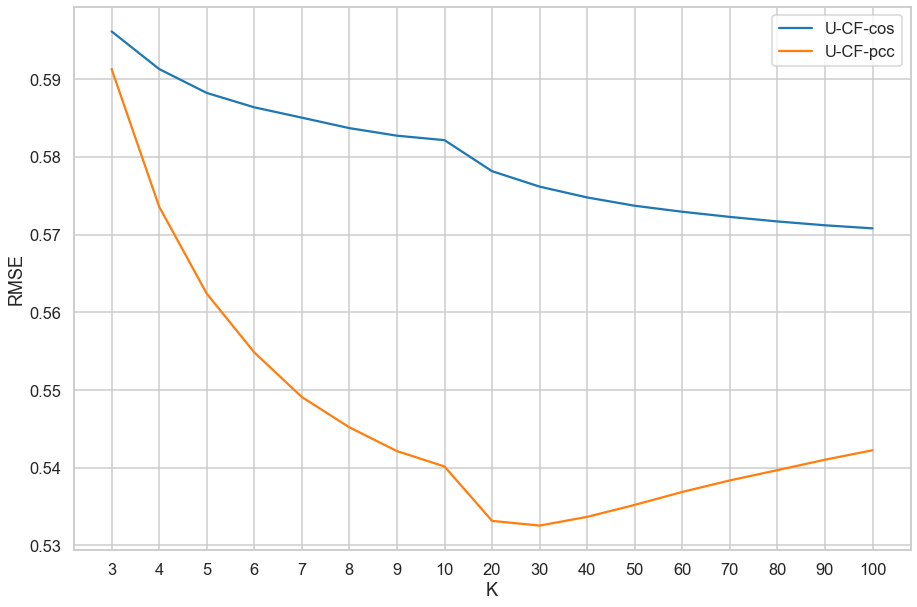

In [393]:
# 將K轉成字串形式
str_k = list(map(lambda x:str(x), K))
# numpy to pandas
df = pd.DataFrame({"K": str_k, "U-CF-cos":ucf_cos, "U-CF-pcc":ucf_pcc})
plot_result(df)